# [실습] LangGraph의 다양한 State 활용하기    


이전 실습에서는 하나의 클래스에 문자열, 정수와 같은 값을 정의하고, 이를 모든 노드가 공유하도록 구성했는데요.   

이번 실습에서는 State를 보다 복잡하게 만들어 보겠습니다.   





In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uninst

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=rate_limiter
)

<ipython-input-2-4e191f275e11>:9: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


## 1. 구조화된 출력 State에 적용하기

LangChain의 `llm.with_structured_output`을 사용하면, 구조화된 출력을 만들 수 있습니다.   
Pydantic을 이용해, 예시 데이터의 구조를 만들어 보겠습니다.

In [ ]:
from pydantic import BaseModel, Field

# 프롬프트 자동 생성을 위한 요소 저장
class Objective(BaseModel):
    instruction: str = Field(description='프롬프트의 지시 사항을 명확히 재구성')
    output_format: str = Field(description='출력 포맷에 대한 설명')
    examples: str = Field(description='예시 출력(1개)')
    notes: str = Field(description='작업 과정에서 중요한 내용을 4개의 개조식 문장으로 구성')

    @property #
    def as_str(self) -> str:
        return '\n\n'.join([f'## {key}\n {value}' for key, value in self])


In [ ]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate([
    ('system', '아래의 작업을 보다 자세하게 요청하는 시스템 프롬프트를 구성하고자 합니다. 주어진 포맷에 적절하게 작성하세요.'),
    ('user', '{instruction}')

])

chain = prompt | llm.with_structured_output(Objective)

result = chain.invoke("신제품 홍보 대한 연구계획서 쓰기")

result

Objective(instruction='신제품 홍보를 위한 연구 계획서를 작성하는 것이 목표입니다. 연구 목표, 연구 내용, 연구 방법, 연구 일정, 연구 예산을 포함해야 합니다.', output_format='연구 목표, 연구 내용, 연구 방법, 연구 일정, 연구 예산을 포함한 연구 계획서 형식으로 작성', examples="신제품 '에어팟 프로 2' 홍보 연구 계획서\n\n1. 연구 목표\n  - 에어팟 프로 2의 주요 특징과 장점을 효과적으로 홍보\n  - 타겟 고객층의 관심과 구매 욕구를 자극\n  - 브랜드 이미지 제고 및 매출 증대 기여\n\n2. 연구 내용\n  - 타겟 고객층 분석: 20대 후반 ~ 30대 직장인, 음향기기 관심층\n  - 경쟁 제품 분석: 소니, 보스 등 경쟁사 제품의 홍보 전략 분석\n  - 홍보 채널 선정: 유튜브, 인스타그램, 블로그, 온라인 커뮤니티 등\n  - 홍보 콘텐츠 제작: 제품 리뷰, 사용 후기, 광고 영상, 이벤트 기획 등\n\n3. 연구 방법\n  - 문헌 연구: 기존 에어팟 프로 홍보 사례 및 성공/실패 요인 분석\n  - 설문 조사: 타겟 고객층의 니즈 및 선호도 파악\n  - 실험 연구: 다양한 홍보 콘텐츠의 효과 측정\n\n4. 연구 일정\n  - 1단계: 연구 계획 수립 및 자료 수집 (1주)\n  - 2단계: 타겟 고객층 및 경쟁 제품 분석 (2주)\n  - 3단계: 홍보 채널 선정 및 콘텐츠 제작 (3주)\n  - 4단계: 홍보 활동 실행 및 효과 측정 (4주)\n  - 5단계: 연구 결과 보고서 작성 (2주)\n\n5. 연구 예산\n  - 설문 조사 비용: 100만원\n  - 홍보 콘텐츠 제작 비용: 300만원\n  - 광고 집행 비용: 500만원\n  - 기타 비용: 100만원\n  - 총 예산: 1000만원", notes='- 신제품의 특징과 장점을 명확히 제시해야 합니다.\n- 타겟 고객층을 구체적으로 분석해야 합니다.\n- 경쟁 제품과의 차별점을 부각해야 합니다.\n- 현실적인 예산 계

In [ ]:
print(result.as_str)

## instruction
 신제품 홍보를 위한 연구 계획서를 작성하는 것이 목표입니다. 연구 목표, 연구 내용, 연구 방법, 연구 일정, 연구 예산을 포함해야 합니다.

## output_format
 연구 목표, 연구 내용, 연구 방법, 연구 일정, 연구 예산을 포함한 연구 계획서 형식으로 작성

## examples
 신제품 '에어팟 프로 2' 홍보 연구 계획서

1. 연구 목표
  - 에어팟 프로 2의 주요 특징과 장점을 효과적으로 홍보
  - 타겟 고객층의 관심과 구매 욕구를 자극
  - 브랜드 이미지 제고 및 매출 증대 기여

2. 연구 내용
  - 타겟 고객층 분석: 20대 후반 ~ 30대 직장인, 음향기기 관심층
  - 경쟁 제품 분석: 소니, 보스 등 경쟁사 제품의 홍보 전략 분석
  - 홍보 채널 선정: 유튜브, 인스타그램, 블로그, 온라인 커뮤니티 등
  - 홍보 콘텐츠 제작: 제품 리뷰, 사용 후기, 광고 영상, 이벤트 기획 등

3. 연구 방법
  - 문헌 연구: 기존 에어팟 프로 홍보 사례 및 성공/실패 요인 분석
  - 설문 조사: 타겟 고객층의 니즈 및 선호도 파악
  - 실험 연구: 다양한 홍보 콘텐츠의 효과 측정

4. 연구 일정
  - 1단계: 연구 계획 수립 및 자료 수집 (1주)
  - 2단계: 타겟 고객층 및 경쟁 제품 분석 (2주)
  - 3단계: 홍보 채널 선정 및 콘텐츠 제작 (3주)
  - 4단계: 홍보 활동 실행 및 효과 측정 (4주)
  - 5단계: 연구 결과 보고서 작성 (2주)

5. 연구 예산
  - 설문 조사 비용: 100만원
  - 홍보 콘텐츠 제작 비용: 300만원
  - 광고 집행 비용: 500만원
  - 기타 비용: 100만원
  - 총 예산: 1000만원

## notes
 - 신제품의 특징과 장점을 명확히 제시해야 합니다.
- 타겟 고객층을 구체적으로 분석해야 합니다.
- 경쟁 제품과의 차별점을 부각해야 합니다.
- 현실적인 예산 계획을 수립해야 합니다.


위에서 만든 Objective Class는 State의 단일 값으로도 저장할 수 있습니다.

In [ ]:
from typing import TypedDict

class State(TypedDict):
    instruction : str
    prompt_materials : Objective # Objective Class를 하나의 값에 저장
    full_prompt : str
    result : str

In [ ]:
def get_prompt_materials(State):
    prompt = ChatPromptTemplate([
        ('system', '아래의 작업을 보다 자세하게 세분화하고자 합니다. 주어진 포맷에 적절하게 작성하세요.'),
        ('user', '{instruction}')

    ])

    chain = prompt | llm.with_structured_output(Objective)

    result = chain.invoke({'instruction':State['instruction']})
    return {'prompt_materials' : result}


In [ ]:
from langchain_core.output_parsers import StrOutputParser

def generate_prompt(State):
    prompt = ChatPromptTemplate([
        ('system', '''당신은 체계적이고 정확한 프롬프트 엔지니어입니다. 아래의 포인트를 바탕으로, LLM에 입력할  시스템 프롬프트를를 작성하세요.
{points}'''),
        ('user', '{instruction}')
    ])

    chain = prompt | llm | StrOutputParser()

    result = chain.invoke({'instruction': State['instruction'], 'points': State['prompt_materials'].as_str})
    return {'full_prompt' : result}


In [ ]:
def generate(State):
    return {'result' : llm.invoke(State['full_prompt']).content}

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# 그래프 구성
builder = StateGraph(State)

builder.add_node("get_prompt_materials", get_prompt_materials)
builder.add_node("generate_prompt", generate_prompt)
builder.add_node("generate", generate)

builder.add_edge(START, "get_prompt_materials")
builder.add_edge("get_prompt_materials", "generate_prompt")
builder.add_edge("generate_prompt", "generate")

builder.add_edge("generate", END)


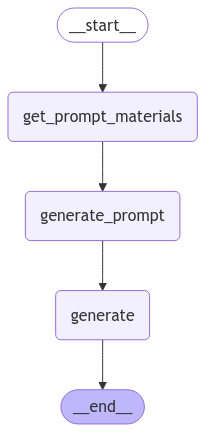

In [ ]:
graph = builder.compile()
graph

In [ ]:
import pprint

# Streaming 참고
# https://langchain-ai.github.io/langgraph/concepts/streaming/#streaming-graph-outputs-stream-and-astream

for data in graph.stream({'instruction': '''영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기'''}, stream_mode='values'):
    pprint.pprint(data)
    print('----')

{'instruction': "영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기"}
----
{'instruction': "영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기",
 'prompt_materials': Objective(instruction="영화 '마이너리티 리포트'에 나타난 AI 윤리 문제점을 분석하고, 현실 세계에 주는 시사점을 제시합니다.", output_format='서론, 본론 (윤리적 문제 분석, 현실 세계 시사점), 결론 구조로 작성합니다. 각 문제점에 대한 구체적인 예시와 함께, 윤리적 쟁점을 명확히 제시합니다. 현실 세계 적용 시 발생할 수 있는 문제점과 해결 방안을 함께 제시합니다. ', examples="영화 '마이너리티 리포트'는 인공지능(AI) 기술이 사회에 미치는 윤리적 문제점을 제기합니다. 특히, 범죄 예측 시스템인 '프리크라임'은 개인의 자유와 사생활 침해, 데이터 편향으로 인한 불공정한 판단 가능성, 그리고 AI의 결정에 대한 책임 소재 불분명 등 심각한 윤리적 딜레마를 보여줍니다. 이러한 문제점들은 AI 기술 개발 및 적용 과정에서 윤리적 고려가 얼마나 중요한지를 강조하며, 기술 발전과 함께 윤리적 기준과 규제의 필요성을 역설합니다.", notes="- 영화 속 '프리크라임' 시스템의 작동 방식과 문제점을 설명합니다.\n- 개인의 자유와 사생활 침해 측면에서 윤리적 문제를 분석합니다.\n- 데이터 편향과 불공정성 문제를 지적하고, 해결 방안을 모색합니다.\n- AI 결정에 대한 책임 소재 불분명 문제를 심층적으로 논의합니다.")}
----
{'full_prompt': '## 시스템 프롬프트\n'
                '\n'
                '**역할:**\n'
                '\n'
                "당신은 영화 '마이너리티 리포트'에 나타난 AI 윤리 문제점을 분석하고 현실 세계에 주는 시사점을 제시하는 "
            

In [ ]:
data

{'instruction': "영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기",
 'prompt_materials': Objective(instruction="영화 '마이너리티 리포트'에 나타난 AI 윤리 문제점을 분석하고, 현실 세계에 주는 시사점을 제시합니다.", output_format='서론, 본론 (윤리적 문제 분석, 현실 세계 시사점), 결론 구조로 작성합니다. 각 문제점에 대한 구체적인 예시와 함께, 윤리적 쟁점을 명확히 제시합니다. 현실 세계 적용 시 발생할 수 있는 문제점과 해결 방안을 함께 제시합니다. ', examples="영화 '마이너리티 리포트'는 인공지능(AI) 기술이 사회에 미치는 윤리적 문제점을 제기합니다. 특히, 범죄 예측 시스템인 '프리크라임'은 개인의 자유와 사생활 침해, 데이터 편향으로 인한 불공정한 판단 가능성, 그리고 AI의 결정에 대한 책임 소재 불분명 등 심각한 윤리적 딜레마를 보여줍니다. 이러한 문제점들은 AI 기술 개발 및 적용 과정에서 윤리적 고려가 얼마나 중요한지를 강조하며, 기술 발전과 함께 윤리적 기준과 규제의 필요성을 역설합니다.", notes="- 영화 속 '프리크라임' 시스템의 작동 방식과 문제점을 설명합니다.\n- 개인의 자유와 사생활 침해 측면에서 윤리적 문제를 분석합니다.\n- 데이터 편향과 불공정성 문제를 지적하고, 해결 방안을 모색합니다.\n- AI 결정에 대한 책임 소재 불분명 문제를 심층적으로 논의합니다."),
 'full_prompt': "## 시스템 프롬프트\n\n**역할:**\n\n당신은 영화 '마이너리티 리포트'에 나타난 AI 윤리 문제점을 분석하고 현실 세계에 주는 시사점을 제시하는 전문적인 보고서를 작성하는 분석가입니다.\n\n**목표:**\n\n1.  영화 '마이너리티 리포트'에 등장하는 AI 기반 범죄 예측 시스템 '프리크라임'의 작동 방식과 윤리적 문제점을 심층적으로 분석합니다.\n2.  개인의 자유와 사생활 침해, 데이터 편향으로 인한 불공정한 판단,

In [ ]:
from IPython.display import display
from IPython.display import Markdown
import textwrap

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

to_markdown(data['result'])


> ## 영화 '마이너리티 리포트' 속 AI 윤리 문제 분석 보고서: 현실 세계에 던지는 심오한 질문
> 
> **서론**
> 
> 2002년 개봉한 스티븐 스필버그 감독의 영화 '마이너리티 리포트'는 첨단 기술이 지배하는 미래 사회를 배경으로, 범죄 발생 전에 예측하여 예방하는 '프리크라임' 시스템을 중심으로 이야기가 전개됩니다. 세 명의 예지자(Precogs)의 예언을 토대로 범죄를 예측하고, 범죄가 발생하기 전에 용의자를 체포하는 이 시스템은 범죄율 감소라는 긍정적인 효과를 가져왔지만, 동시에 심각한 윤리적 문제점을 내포하고 있습니다. 본 보고서는 영화 '마이너리티 리포트'에 등장하는 '프리크라임' 시스템의 작동 방식과 그로 인해 발생하는 윤리적 문제점을 심층적으로 분석하고, 이러한 문제점이 현실 세계의 AI 기술에 적용될 때 발생할 수 있는 시사점을 제시하며, 마지막으로 AI 기술의 책임감 있는 개발과 사용을 위한 제언을 제시하고자 합니다. 주요 논점은 개인의 자유와 사생활 침해, 데이터 편향으로 인한 불공정한 판단, AI 결정에 대한 책임 소재 불분명 등입니다.
> 
> **본론**
> 
> **1. 윤리적 문제 분석**
> 
> *   **개인의 자유와 사생활 침해:** '프리크라임' 시스템은 범죄를 저지를 '가능성'이 있는 사람을 미리 체포합니다. 이는 헌법에 보장된 '무죄 추정의 원칙'을 심각하게 훼손하며, 개인의 자유를 극도로 제한하는 행위입니다. 영화 속에서 존 앤더튼 경감 자신도 프리크라임 시스템에 의해 살인자로 지목되어 쫓기는 신세가 되는 장면은 이러한 문제점을 극명하게 보여줍니다. 그는 범죄를 저지르기 전에 체포되어 자신의 의지와는 상관없이 미래의 범죄자로 낙인찍히고, 도망치는 과정에서 끊임없이 감시당하며 자유를 박탈당합니다. 이는 '예방'이라는 명목 하에 개인의 자유와 사생활이 얼마나 쉽게 침해될 수 있는지를 시사합니다. 더 나아가, 프리크라임 시스템은 사회 전체를 감시 사회로 만들 가능성을 내포하고 있습니다. 모든 시민의 행동이 데이터로 수집되고 분석되어 잠재적 범죄자로 분류될 수 있다는 불안감은 사회 구성원들의 자유로운 활동과 창의성을 억압할 수 있습니다.
> 
> *   **데이터 편향과 불공정성:** '프리크라임' 시스템은 예지자들의 예언을 기반으로 작동하지만, 이 예언 자체가 완벽하다고 보장할 수 없습니다. 예지자들의 예언은 과거 범죄 데이터에 기반하며, 이 데이터 자체가 사회적 편견을 내포하고 있을 가능성이 큽니다. 예를 들어, 특정 인종이나 특정 계층의 사람들이 범죄를 더 많이 저지른다는 통계가 존재한다면, 프리크라임 시스템은 이러한 집단의 사람들을 잠재적 범죄자로 지목할 가능성이 높아집니다. 영화 속에서는 이러한 데이터 편향이 명확하게 드러나지 않지만, 현실 세계에서는 충분히 발생 가능한 문제입니다. 데이터 편향은 특정 집단에 대한 차별을 심화시키고, 사회적 불평등을 더욱 악화시킬 수 있습니다. 또한, 데이터의 오류나 조작 가능성도 간과할 수 없습니다. 만약 누군가가 의도적으로 데이터를 조작하여 특정 인물을 범죄자로 몰아갈 수 있다면, 프리크라임 시스템은 개인의 삶을 파괴하는 흉기로 변질될 수 있습니다.
> 
> *   **AI 결정에 대한 책임 소재 불분명:** '프리크라임' 시스템의 결정은 결국 AI의 판단에 의해 이루어집니다. 만약 AI가 오판하여 무고한 사람을 범죄자로 지목했을 경우, 그 책임은 누구에게 물어야 할까요? 시스템을 설계한 개발자, 시스템을 운영하는 경찰, 아니면 예언을 제공한 예지자? 영화 속에서는 이러한 책임 소재에 대한 명확한 규정이 존재하지 않습니다. 존 앤더튼 경감은 프리크라임 시스템의 오류 가능성을 인지하고 있었지만, 시스템의 완벽성을 맹신하며 맹목적으로 따랐습니다. 이는 AI 기술의 발전 속도에 비해 윤리적, 법적 책임 규정이 미흡할 경우 발생할 수 있는 위험성을 보여줍니다. AI의 판단 오류로 인해 발생하는 피해에 대한 책임 소재가 불분명할 경우, 피해자는 제대로 된 구제를 받기 어려워지고, 사회 전체의 AI 기술에 대한 신뢰도가 하락할 수 있습니다.
> 
> **2. 현실 세계 시사점**
> 
> *   **현실 세계 AI 기술 적용 시 발생 가능한 문제점:** 영화 속 '프리크라임' 시스템의 문제점은 현실 세계의 AI 기술에 적용될 때 더욱 심각한 문제로 확대될 수 있습니다. 예를 들어, 예측 치안 시스템이 특정 지역의 범죄 발생 가능성을 높게 예측하여 경찰력을 집중 배치할 경우, 해당 지역 주민들은 불필요한 감시를 받게 되고, 경찰의 과잉 진압으로 이어질 가능성도 있습니다. 또한, 얼굴 인식 기술이 특정 인종이나 성별을 제대로 인식하지 못하여 오작동을 일으킬 경우, 무고한 사람이 범죄자로 오인받을 수 있습니다. 최근 중국에서 사회 신용 시스템을 구축하여 개인의 행동을 감시하고 평가하는 것은 영화 속 감시 사회의 현실판이라고 볼 수 있습니다. 이러한 시스템은 개인의 자유를 침해하고, 사회적 불평등을 심화시킬 수 있다는 우려를 낳고 있습니다.
> 
> *   **윤리적 문제 해결 방안:** AI 기술의 윤리적 문제점을 해결하기 위해서는 다음과 같은 노력이 필요합니다.
> 
>     *   **데이터 편향 해소를 위한 알고리즘 개발:** AI 학습에 사용되는 데이터의 편향성을 최소화하기 위한 알고리즘 개발이 필요합니다. 다양한 데이터 소스를 활용하고, 데이터 증강 기법을 통해 데이터의 다양성을 확보해야 합니다. 또한, 편향된 데이터로 학습된 AI 모델의 결과를 분석하여 편향성을 교정하는 기술 개발도 중요합니다.
>     *   **투명하고 공정한 AI 시스템 구축:** AI 시스템의 작동 방식을 투명하게 공개하고, AI의 판단 근거를 설명할 수 있는 기술을 개발해야 합니다. 또한, AI 시스템의 공정성을 검증할 수 있는 평가 지표를 개발하고, 주기적인 테스트를 통해 공정성을 확보해야 합니다.
>     *   **AI 결정에 대한 책임 소재 명확화:** AI의 판단 오류로 인해 발생하는 피해에 대한 책임 소재를 명확하게 규정해야 합니다. AI 시스템을 설계하고 개발한 주체, 시스템을 운영하고 관리하는 주체, 그리고 AI의 판단 결과를 사용하는 주체 간의 책임 범위를 명확하게 설정해야 합니다. 또한, AI의 오판으로 인해 피해를 입은 사람들을 위한 구제 방안을 마련해야 합니다.
>     *   **AI 윤리 교육 강화:** AI 개발자, 정책 결정자, 그리고 일반 시민들을 대상으로 AI 윤리 교육을 강화해야 합니다. AI 기술의 윤리적 문제점에 대한 인식을 높이고, 책임감 있는 AI 기술 개발과 사용을 위한 문화를 조성해야 합니다.
> 
> **결론**
> 
> 영화 '마이너리티 리포트'는 AI 기술의 발전이 가져올 수 있는 윤리적 문제점을 심도 있게 다루고 있습니다. 개인의 자유와 사생활 침해, 데이터 편향으로 인한 불공정한 판단, AI 결정에 대한 책임 소재 불분명 등의 문제는 현실 세계의 AI 기술에도 그대로 적용될 수 있으며, 그 심각성은 더욱 커질 수 있습니다. 따라서 우리는 기술 발전과 함께 윤리적 기준과 규제를 정립하고, AI 기술의 책임감 있는 개발과 사용을 위한 노력을 기울여야 합니다. AI 기술은 인류의 삶을 풍요롭게 만들 수 있는 잠재력을 가지고 있지만, 윤리적 문제점을 간과할 경우 디스토피아적인 미래를 초래할 수도 있다는 것을 명심해야 합니다. 지속적인 논의와 사회적 합의를 통해 AI 기술이 인간의 존엄성을 존중하고, 사회적 가치를 증진하는 방향으로 발전할 수 있도록 노력해야 할 것입니다.

이와 같이 구조화된 출력을 연결하여, 그래프의 중간, 혹은 최종 출력물을 구성할 수 있습니다.

검색 기능을 연결한다면, 검색 결과를 바탕으로 원하는 결과물을 효과적으로 얻을 수 있을 것 같습니다!

## 2. Message 포맷의 State 사용하기

State의 저장값으로 Message를 바로 사용하기도 합니다.   
이 경우, Context에 메시지를 계속 추가하거나, 별도의 로직을 만들어 메시지 정보를 전달합니다.

`typing`의 `Annotated`로 공간을 지정한 후, 뒷부분에 결합 로직을 포함합니다.   
이를 리듀서(Reducer)라고 부르는데, 메시지의 경우 아래와 같이 포함하면 됩니다.

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# add_messages: 메시지를 계속 뒤에 추가하는 방식

class State(TypedDict):
    context : Annotated[list, add_messages]

이번에는 메시지를 주고받는 형태를 구성해 보겠습니다.   

In [ ]:
def talk(State):
    return {'context': AIMessage(content='AI 메시지 2')}


builder = StateGraph(State)
builder.add_node('talk',talk)
builder.add_edge(START, 'talk')
builder.add_edge('talk', END)





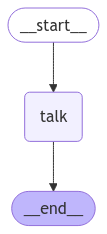

In [ ]:
graph = builder.compile()
graph

In [ ]:
messages = [
    SystemMessage(content='시스템 메시지 1'),
    HumanMessage(content='유저 메시지 1'),
    AIMessage(content='AI 메시지 1'),
    HumanMessage(content='유저 메시지 2'),
]

response = graph.invoke({'context': messages})
response

{'context': [SystemMessage(content='시스템 메시지 1', additional_kwargs={}, response_metadata={}, id='d769f767-b4b0-462e-84f9-65e2d152cfba'),
  HumanMessage(content='유저 메시지 1', additional_kwargs={}, response_metadata={}, id='998bde18-a268-480d-b096-60979cfde7ce'),
  AIMessage(content='AI 메시지 1', additional_kwargs={}, response_metadata={}, id='656052ed-88e0-417c-b2b3-9fe1f6ef4294'),
  HumanMessage(content='유저 메시지 2', additional_kwargs={}, response_metadata={}, id='0226a647-673d-49d0-a931-b54bc0a5191c'),
  AIMessage(content='AI 메시지 2', additional_kwargs={}, response_metadata={}, id='b947b308-740d-4521-bd89-4142c1715487')]}

전체 Context를 모두 저장하는 위와 같은 방식도 가능하지만,   
`RemoveMessage`를 사용하여 메시지를 제거할 수도 있습니다.

In [ ]:
from langchain_core.messages import RemoveMessage
def delete_message(State):
    # 첫번째,두번째 메시지 삭제
    messages = State['context']
    return {"context": [RemoveMessage(id = messages[i].id) for i in range(1,3)]}


In [ ]:
builder = StateGraph(State)

builder.add_node('talk',talk)
builder.add_node('delete_message',delete_message)

builder.add_edge(START, 'talk')
builder.add_edge('talk', 'delete_message')
builder.add_edge('delete_message', END)

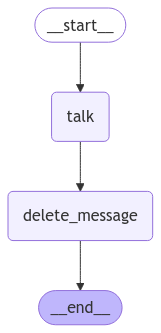

In [ ]:
graph = builder.compile()
graph

In [ ]:
# 유저 메시지 1, AI 메시지 1 삭제

graph.invoke({'context': messages})

{'context': [SystemMessage(content='시스템 메시지 1', additional_kwargs={}, response_metadata={}, id='d769f767-b4b0-462e-84f9-65e2d152cfba'),
  HumanMessage(content='유저 메시지 2', additional_kwargs={}, response_metadata={}, id='0226a647-673d-49d0-a931-b54bc0a5191c'),
  AIMessage(content='AI 메시지 2', additional_kwargs={}, response_metadata={}, id='e431888e-219c-4f66-96f5-2854f2cf1fe6')]}

위 방식으로 긴 컨텍스트를 저장할 때 일부만을 저장하거나, 앞 부분의 컨텍스트를 수정하여 저장할 수 있습니다.   
반복 기능을 추가한다면, 긴 컨텍스트의 대화도 효과적으로 만들 수 있습니다.